In [3]:
import torch
import csv
from torch import nn
import torch.nn.functional as F
import numpy as np
import torchinfo
import math
import matplotlib.pyplot as plt
from tqdm import tqdm


# Load data and create pytorch dataset


There are 729 wells in total, assuming no interference (the wells are independent and are not influenced by newcoming wells).
Each well has 157 timesteps, the timestamps start at 0 and increment by 7 every step. 
h is fracture height, l is fracture length, and k is fracture permeability.
bhp is bottom hole pressure and can vary per timestep. 
The goal is to predict qg (gas production), qo (oil production) and qw (water production) over 157 timesteps.

In [8]:
# Load data from csv into numpy array

from sklearn.preprocessing import MinMaxScaler

NUM_WELLS = 729
NUM_TIMESTEP = 157
NUM_FEATURES = 8 - 1 # remove the time column. Does not affect the outcome
csv_data = np.zeros([114453, 8])
with open("MFS729_addnoise_0829.csv") as csv_file:
    reader = csv.reader(csv_file, delimiter=",")
    
    well_index = -1
    timestep_index = 0
    
    for i, row in enumerate(reader):
        
        if i == 0: # Header
            continue
        
        csv_data[i - 1, :] = row[:]

# Transformation
transformation = MinMaxScaler()
transformation.fit(csv_data)
csv_data = transformation.transform(csv_data)
        
data = np.zeros((NUM_WELLS, NUM_TIMESTEP, NUM_FEATURES))

for i, row in enumerate(csv_data):
    if (i) % 157 == 0:
        well_index += 1
        timestep_index = 0 
    
    row = row.tolist()
    row.pop(3)
    data[well_index][timestep_index] = np.array(row)
    timestep_index += 1

        
data[:, :, [3, 6]] = data[:, :, [6, 3]] # Swap bottomhole pressure with gas production rate for later simplicity
print(data.shape)

(729, 157, 7)


In [9]:
# Build Pytorch dataset and dataloader

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data_as_numpy):
        self.data = torch.from_numpy(data_as_numpy)
        self.features = data[:, :, 0:4]
        self.target = data[:, :, 4: ]
        
    def __getitem__(self, index):
        x = self.features[index]
        y = self.target[index]    
        x, y = x, y
        return x, y
    def __len__(self):
        return self.data.shape[0]
 
        


In [37]:
# Create dataset and loaders
dataset = CustomDataset(data)
train_set, test_set = torch.utils.data.random_split(dataset, [629,100])


train_loader = torch.utils.data.DataLoader(train_set, batch_size = 16, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=False)

print(dataset[200, :5, :])

(array([[0.25      , 0.5       , 0.25      , 0.07443806],
       [0.25      , 0.5       , 0.25      , 0.07443806],
       [0.25      , 0.5       , 0.25      , 0.07298528],
       [0.25      , 0.5       , 0.25      , 0.07142592],
       [0.25      , 0.5       , 0.25      , 0.06932538]]), array([[0.51230491, 0.42859503, 0.60510204],
       [0.25853664, 0.28018948, 0.26059696],
       [0.21157909, 0.22901122, 0.24769082],
       [0.21460042, 0.22839515, 0.24853912],
       [0.18154546, 0.20389558, 0.19724659]]))


# Define the model


Supervised Autoencoder LSTM. Instead of predicting y, we predict y and at the same time try to reconstruct x. The loss will be the summation of the loss between y and y_hat, plus the loss between x and x_hat. This way, we hope the encoder will learn some valuable features about x, thus improving its performance when predicting y.

In [11]:

class SAE_LSTM(nn.Module):
    def __init__(self):
        super(SAE_LSTM, self).__init__()
        
        #--------encoder------------#
        self.lstm1 = nn.LSTM(input_size = 4, hidden_size= 128, batch_first = True, num_layers = 3, dropout = 0.5)
        #--------decoder_reconstruct------------#
        self.lstm2 = nn.LSTM(input_size = 128, hidden_size= 4, batch_first = True, num_layers = 3, dropout = 0.5)
        self.reconstruct_linear = nn.Linear(12, 628)
        #--------decoder_output-----------------#
        self.lstm3 = nn.LSTM(input_size = 128, hidden_size = 3, batch_first = True, num_layers = 3, dropout = 0.5)
        self.predict_linear = nn.Linear(9,471)
        
        
    def forward(self, x):
        #------encode--------#
        x, (_, _) = self.lstm1(x)
        #------decode--------#
        x_hat, (h_reconstruct, _) = self.lstm2(x)
        h_reconstruct = torch.flatten(h_reconstruct)
        x_hat = self.reconstruct_linear(h_reconstruct)
        #------predict-------#
        x, (h_predict, _) = self.lstm3(x)   
        h_predict = torch.flatten(h_predict)
        x = self.predict_linear(h_predict)
        
        return x.reshape([157, 3]), x_hat.reshape([157, 4])


test = SAE_LSTM()
torchinfo.summary(test, (157, 4))



Layer (type:depth-idx)                   Output Shape              Param #
SAE_LSTM                                 [157, 3]                  --
├─LSTM: 1-1                              [157, 128]                332,800
├─LSTM: 1-2                              [157, 4]                  2,464
├─Linear: 1-3                            [628]                     8,164
├─LSTM: 1-4                              [157, 3]                  1,788
├─Linear: 1-5                            [471]                     4,710
Total params: 349,926
Trainable params: 349,926
Non-trainable params: 0
Total mult-adds (G): 6.70
Input size (MB): 0.00
Forward/backward pass size (MB): 0.18
Params size (MB): 1.40
Estimated Total Size (MB): 1.58

Traditional LSTM, no supervised auto encoder and there is only one loss function.

In [23]:

class Traditional_LSTM(nn.Module):
    def __init__(self):
        super(Traditional_LSTM, self).__init__()
        
        self.lstm1 = nn.LSTM(input_size = 4, hidden_size= 64, batch_first = True, num_layers = 2, dropout = 0.5)
    
        self.lstm2 = nn.LSTM(input_size = 64, hidden_size = 3, batch_first = True, num_layers = 2, dropout = 0.5)
        
        self.predict_linear = nn.Linear(157,157)
        
        
    def forward(self, x):
        x, (_, _) = self.lstm1(x)

        x, (h_predict, _) = self.lstm2(x)   
        
        
        x = x.permute(1, 0)
        x = self.predict_linear(x)
        
        return x.reshape([157, 3])


test = Traditional_LSTM()
torchinfo.summary(test, (157, 4))



Layer (type:depth-idx)                   Output Shape              Param #
Traditional_LSTM                         [157, 3]                  --
├─LSTM: 1-1                              [157, 64]                 51,200
├─LSTM: 1-2                              [157, 3]                  924
├─Linear: 1-3                            [3, 157]                  24,806
Total params: 76,930
Trainable params: 76,930
Non-trainable params: 0
Total mult-adds (M): 514.97
Input size (MB): 0.00
Forward/backward pass size (MB): 0.09
Params size (MB): 0.31
Estimated Total Size (MB): 0.40

In [35]:
from torch.utils.tensorboard import SummaryWriter

def train(train_loader, model, epochs, beta, reconstruction_loss, prediction_loss, model_name):
    writer = SummaryWriter()
    model.cuda()
    optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-05)
    
    with tqdm(total=epochs) as pbar:
        for epoch in range(epochs):
            model.train()
            model_loss = 0.0
            model_y_loss = 0.0
            for batch_idx, (data,target) in enumerate(train_loader):
                data = data[0].cuda().type(torch.cuda.FloatTensor)
                target = target[0].cuda().type(torch.cuda.FloatTensor)
                optimizer.zero_grad()
                
            
                if reconstruction_loss:
                    y_hat, x_hat = model(data)
                    y_loss = torch.sqrt(prediction_loss(y_hat,target))
                    x_loss = beta*reconstruction_loss(x_hat,data)
                    loss = y_loss + x_loss
                else:
                    y_hat = model(data)
                    y_loss = torch.sqrt(prediction_loss(y_hat,target))
                    loss = y_loss
                    
                loss.backward()
                optimizer.step()
                model_loss += loss/len(train_loader)
                model_y_loss += y_loss/len(train_loader)
            pbar.update(1)
            pbar.set_postfix(**{'train__loss': model_loss.item(), "prediction_loss": model_y_loss.item()})   
            writer.add_scalar("Train loss", model_loss.item(), epoch)
            writer.add_scalar("Prediction loss", model_y_loss.item(), epoch)
            
    
    torch.save(model, model_name + ".pt")
    writer.close()



Training the models

In [8]:

#------------Supervised autoencoder LSTM--------------------#
epochs = 350
reconstruction_loss = nn.L1Loss()
prediction_loss = nn.MSELoss()
beta = 0.5
print("-----------------SAE_LSTM training-----------------------")
sae_lstm = SAE_LSTM()
train(train_loader = train_loader, model = sae_lstm, epochs = epochs, beta = beta, reconstruction_loss = reconstruction_loss, prediction_loss = prediction_loss, model_name = "sae_lstm")    
print("--------------------END OF SAE_LSTM TRAINING-----------------")


-----------------SAE_LSTM training-----------------------


100%|██████████| 350/350 [05:31<00:00,  1.05it/s, prediction_loss=0.0261, train__loss=0.046] 

--------------------END OF SAE_LSTM TRAINING-----------------


In [38]:

#------------Regular LSTM (repeated static data)--------------------#
epochs = 350
reconstruction_loss = None
prediction_loss = nn.MSELoss()
beta = 0
print("-----------------Traditional_LSTM training-----------------------")
trad_lstm = Traditional_LSTM()
train(train_loader = train_loader, model = trad_lstm, epochs = epochs, beta = beta, reconstruction_loss = reconstruction_loss, prediction_loss = prediction_loss, model_name = "trad_lstm")
print("--------------------END OF Traditional_LSTM TRAINING-----------------")



-----------------Traditional_LSTM training-----------------------


100%|██████████| 350/350 [02:22<00:00,  2.45it/s, prediction_loss=0.0262, train__loss=0.0262]

--------------------END OF Traditional_LSTM TRAINING-----------------


lstm1.weight_ih_l0 tensor([[-0.2522, -0.0692, -0.0056, -0.4552],
        [ 0.0739,  0.0401,  0.0829,  0.4049],
        [-0.2915, -0.1124, -0.1777, -0.3171],
        ...,
        [-0.0951, -0.1585, -0.1957, -0.0556],
        [-0.1143, -0.7733, -0.4359, -0.4852],
        [ 0.0651, -0.2566, -0.0230, -0.2194]], device='cuda:0')
lstm1.weight_hh_l0 tensor([[-0.0535,  0.0425, -0.0259,  ..., -0.0389, -0.1502, -0.1445],
        [ 0.0442,  0.0019,  0.0253,  ...,  0.1432, -0.0582,  0.0303],
        [ 0.0597,  0.1474, -0.0767,  ..., -0.0680, -0.2506, -0.1260],
        ...,
        [-0.0627, -0.1378, -0.0626,  ...,  0.1469, -0.2336, -0.0472],
        [ 0.0858, -0.2108, -0.2402,  ...,  0.1658, -0.2490, -0.0960],
        [ 0.1307, -0.0722, -0.1050,  ..., -0.0059,  0.0209,  0.0005]],
       device='cuda:0')
lstm1.bias_ih_l0 tensor([-9.6008e-02, -5.9748e-02, -8.5058e-02, -1.7875e-01,  1.6763e-01,
        -2.0090e-01, -1.6068e-01, -1.2921e-01, -1.5516e-01, -5.9189e-02,
         1.5109e-02, -1.3506e-01, 

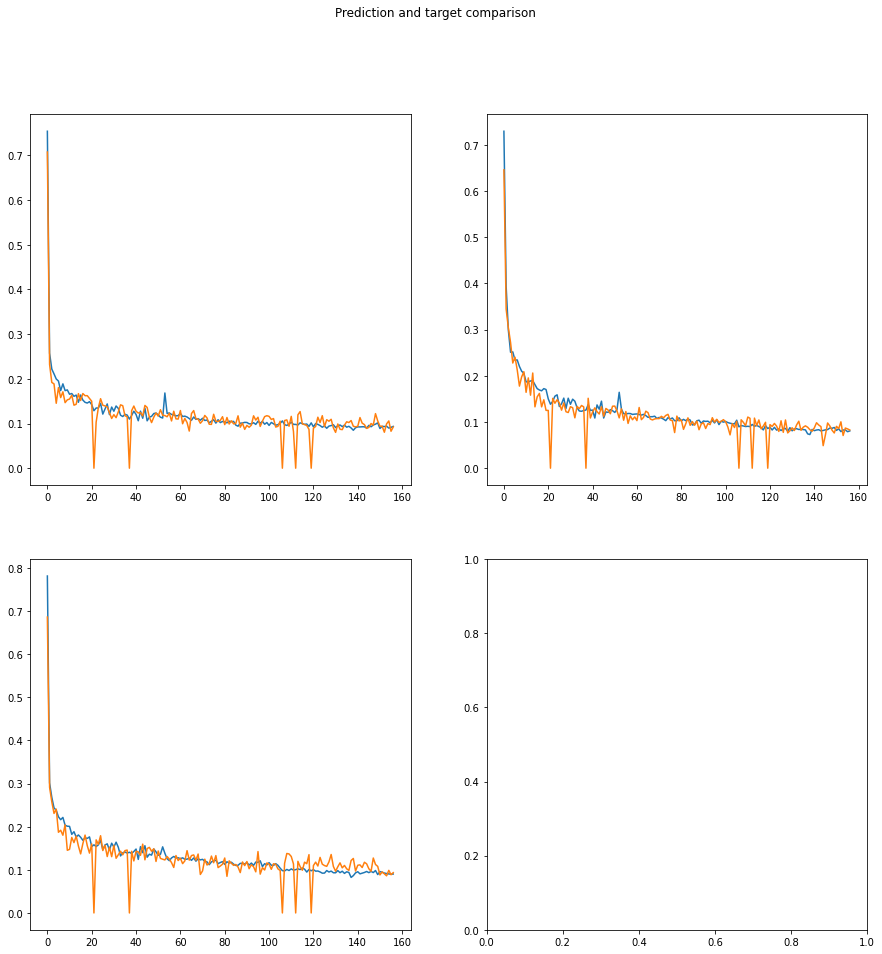

In [42]:
import torch
import numpy as np
MODELNAME = "trad_lstm"

def test(test_loader, model_name):
    
    file_to_load = model_name + ".pt"
    
    if model_name == "trad_lstm":
        test_model = Traditional_LSTM()
    
    elif model_name == "sae_lstm":
        test_model = SAE_LSTM()    
    else:
        print("Invalid model name")
        return None
    
    test_model = torch.load(file_to_load)
    for name, param in test_model.state_dict().items():
        print(name, param)
    
    prediction_loss = nn.MSELoss()
    
    test_model.eval()
    y_hat_graph, x_hat_graph, y_graph, x_graph = None, None, None, None
    model_loss_normalised = 0.0
    model_loss_inversed = 0
    
    for batch_idx, (data,target) in enumerate(test_loader):
        
        
        data = data[0].cuda().type(torch.cuda.FloatTensor)
        target = target[0].cuda().type(torch.cuda.FloatTensor)
        
        if model_name == "sae_lstm":
            y_hat, x_hat = test_model(data)
        else:
            y_hat = test_model(data)
            x_hat = torch.tensor([])
        loss = prediction_loss(y_hat,target)
        if batch_idx == 3:
            y_hat_graph, x_hat_graph, y_graph, x_graph = y_hat, x_hat, target, data
            y_hat_graph, x_hat_graph, y_graph, x_graph = y_hat_graph.detach().cpu().numpy(), x_hat_graph.detach().cpu().numpy(), y_graph.detach().cpu().numpy(), x_graph.detach().cpu().numpy()
        model_loss_normalised += math.sqrt(loss.item())/len(train_loader)
        
        y_hat = torch.nn.functional.pad(y_hat, (0, 5), "constant", 0)
        target = torch.nn.functional.pad(target, (0, 5), "constant", 0)
        
        y_hat = y_hat.detach().cpu().numpy()
        target = target.detach().cpu().numpy()
        
        
        y_hat = transformation.inverse_transform(y_hat)
        target = transformation.inverse_transform(target)
        y_hat = torch.from_numpy(y_hat[:, :3])
        target = torch.from_numpy(target[:, :3])
        
        loss = prediction_loss(y_hat,target)
        model_loss_inversed += math.sqrt(loss.item())/len(train_loader)
        
        
    print('test_loss_normalised: ', model_loss_normalised)
    print('test_loss_inversed: ', model_loss_inversed)
    
    
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 15))
    
        
    fig.suptitle("Prediction and target comparison")
    
    ax1.plot([i for i in range(157)], y_hat_graph[:, 0], label = "qo_hat")
    ax1.plot([i for i in range(157)], y_graph[:, 0], label = "qo")
    
    ax2.plot([i for i in range(157)], y_hat_graph[:, 1], label = "qw_hat")
    ax2.plot([i for i in range(157)], y_graph[:, 1], label = "qw")
    
    ax3.plot([i for i in range(157)], y_hat_graph[:, 2], label = "qg_hat")
    ax3.plot([i for i in range(157)], y_graph[:, 2], label = "qg")
    
    if model_name == "sae_lstm":
        ax4.plot([i for i in range(157)], x_hat_graph[:, 3], label = "bhp_hat")
        ax4.plot([i for i in range(157)], x_graph[:, 3], label = "bhp")
    
    
    plt.show()

test(test_loader=test_loader, model_name="trad_lstm")
